# CarND-Advanced-Lane-Lines 

## Camera Calibration

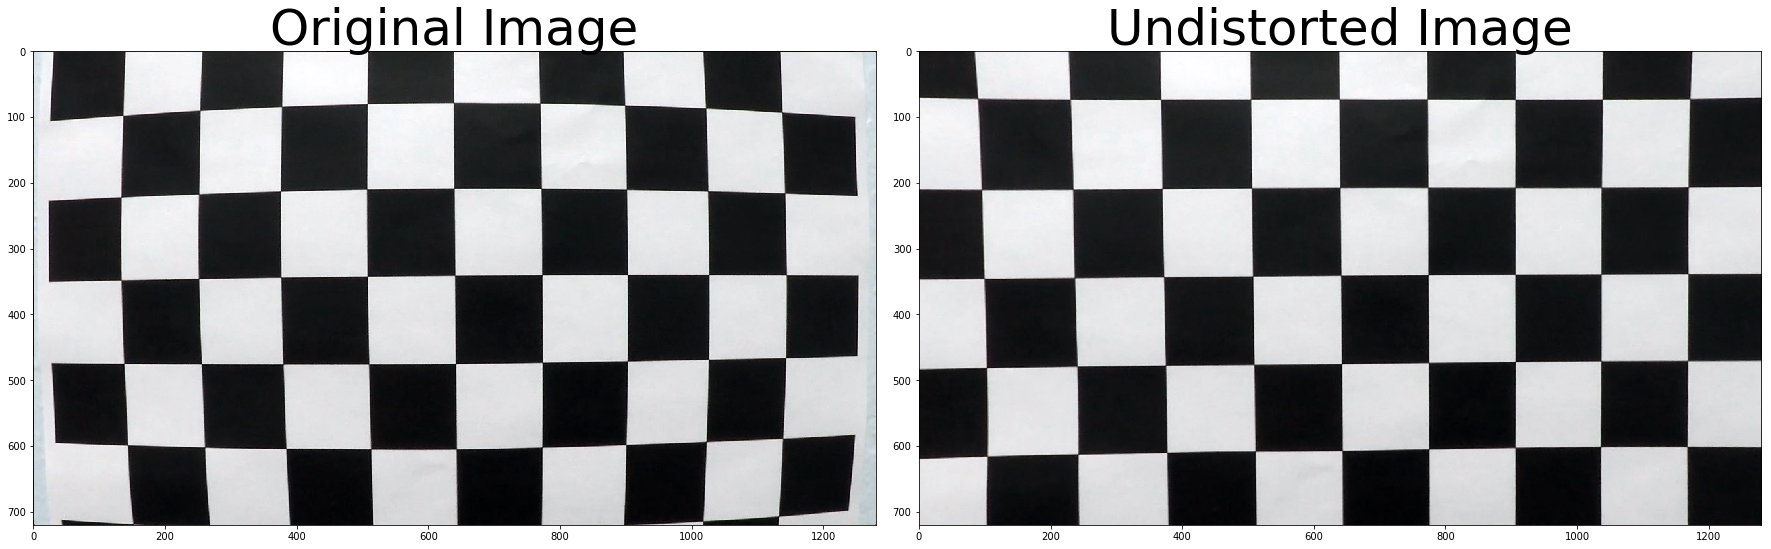

In [122]:
#importing some useful packages
%matplotlib inline
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Get objpoints and imgpoints
def get_corners(ny, nx):
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # get the chess board corner
        ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (ny, nx), corners, ret)
    return objpoints, imgpoints

# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# calculate corners
objpoints, imgpoints = get_corners(6, 9)
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
# get the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (single images)
I'll show lane detection pipeline for single images as follows.

### undistorted road image

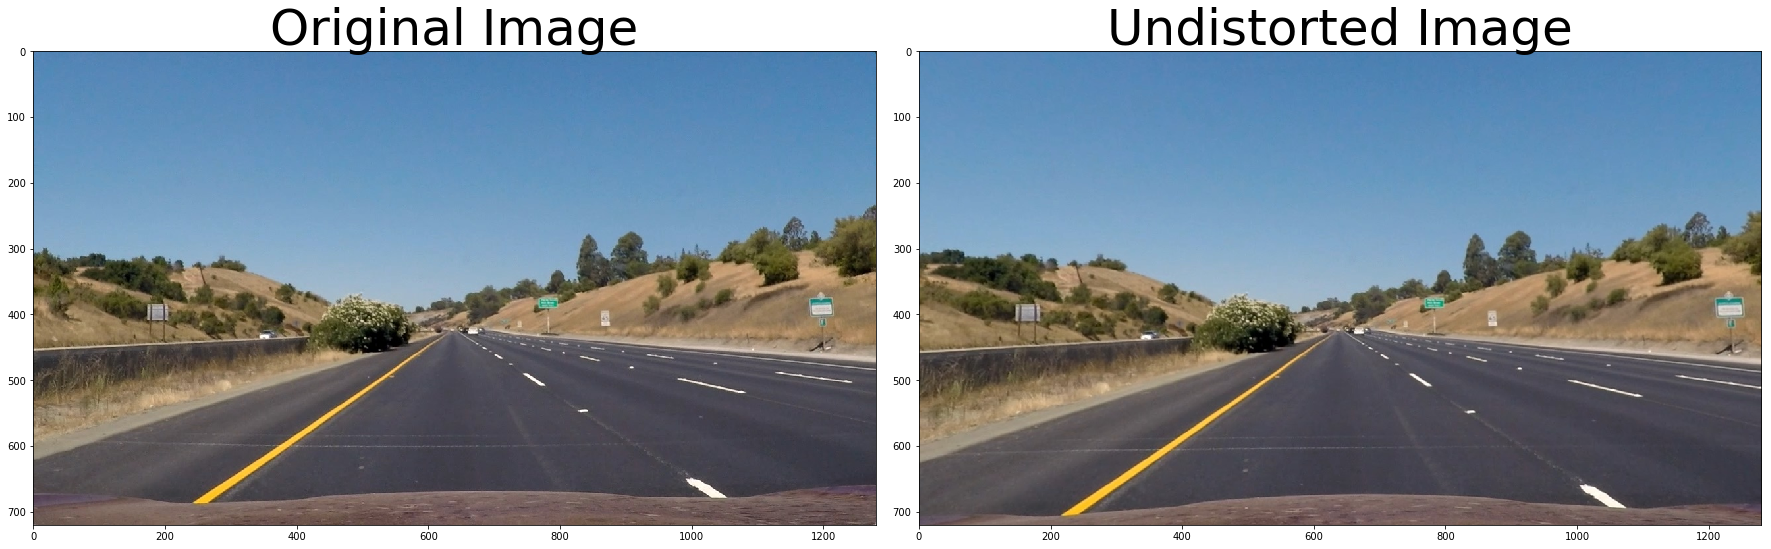

In [123]:
#reading in an image
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# get the undistorted image
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color transoformation and gradients image

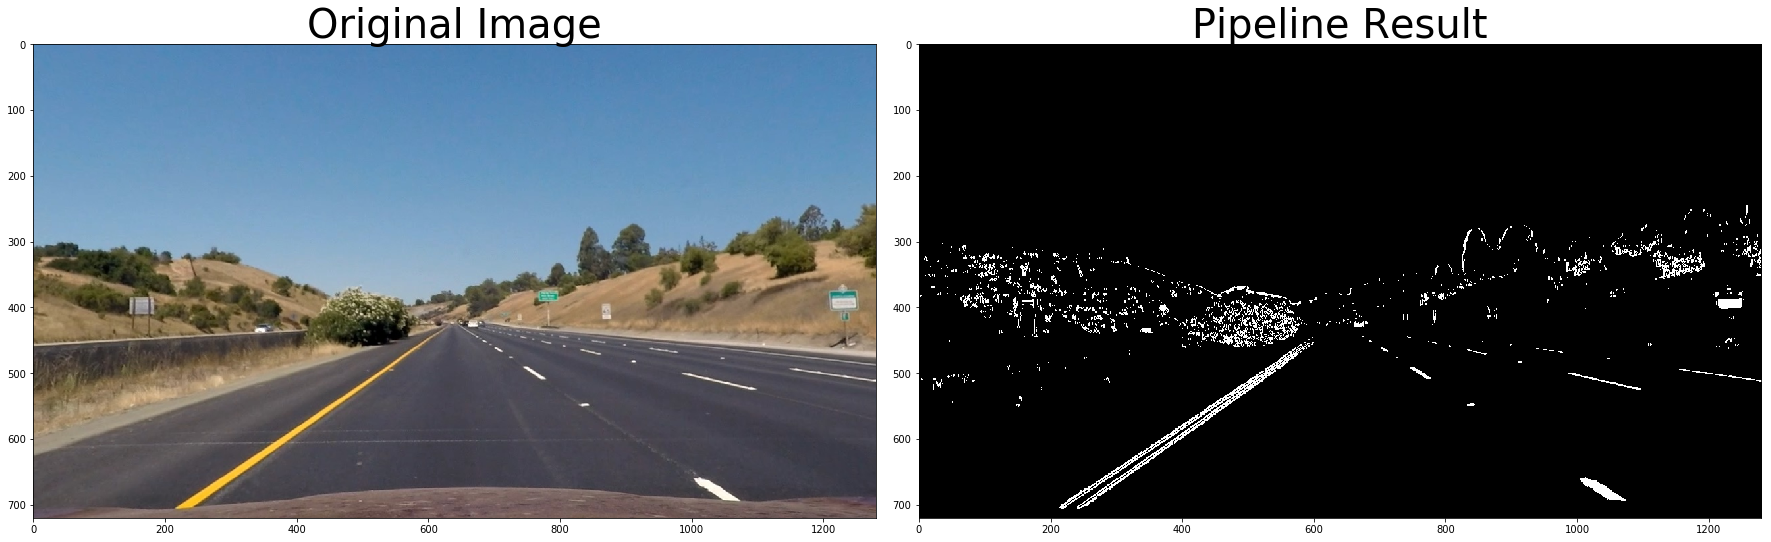

In [124]:
def pipeline(img, s_thresh=(170, 255), l_thresh=(240, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    white_img = cv2.inRange(hsv, (0, 0, 170), (255, 25, 255))
    white_binary = np.zeros_like(white_img)
    white_binary[white_img > 0] = 1
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (l_binary == 1) | (white_binary == 1)] = 1
    return color_binary, combined_binary
    
color_binary, combined_binary = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective transoformation

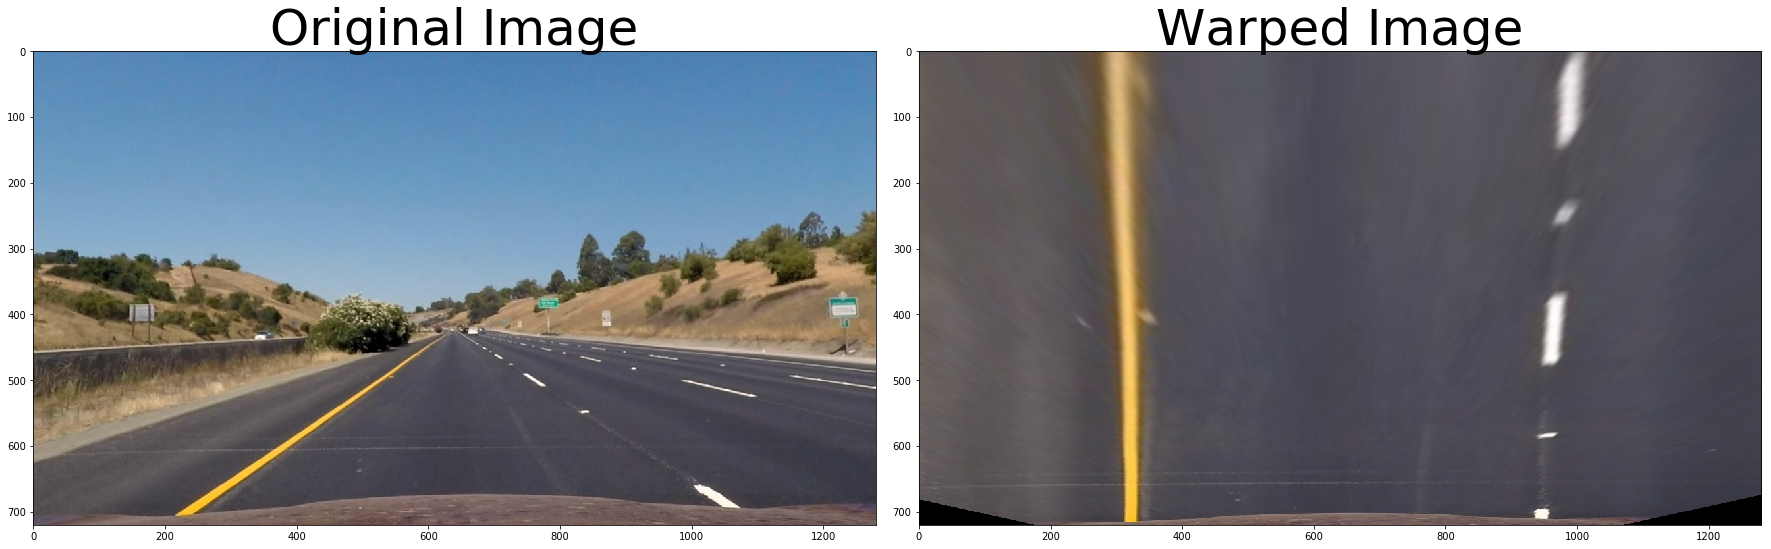

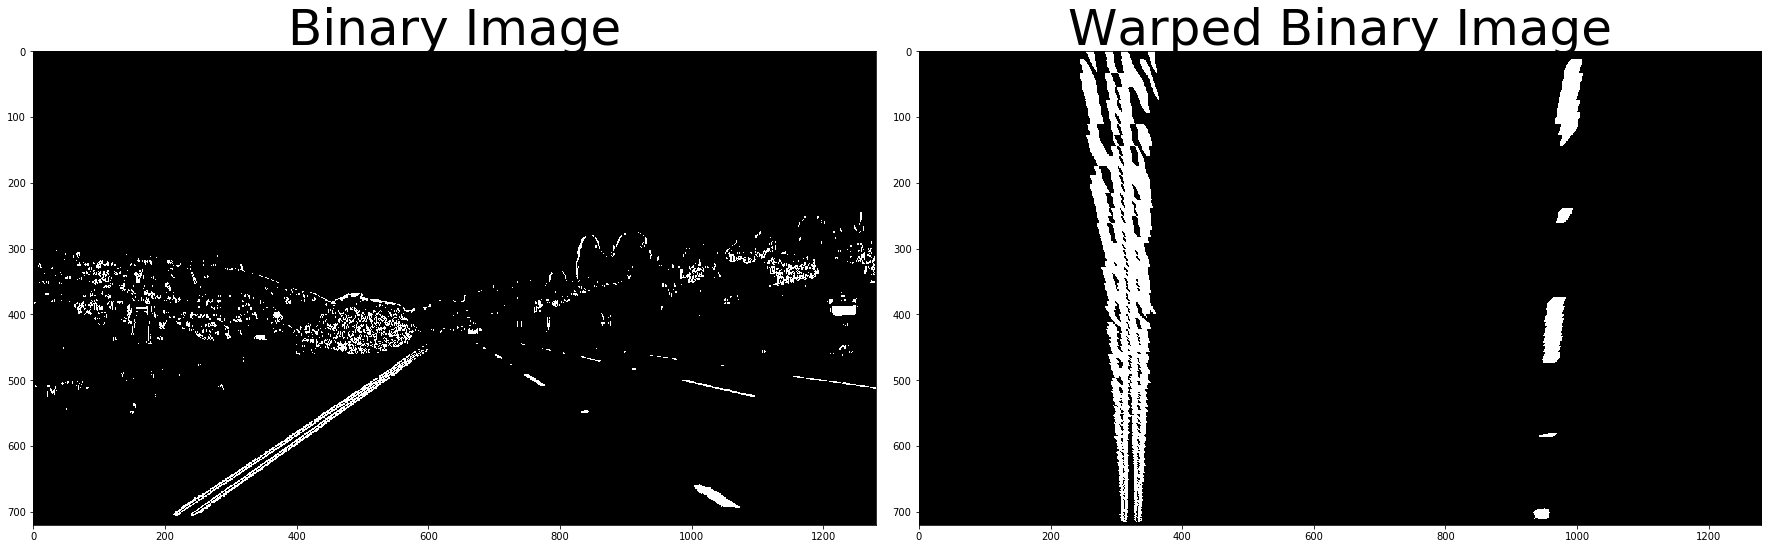

In [125]:
def warp_transform(img):
    img_size = img.shape
    src = np.float32(
        [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
        [((img_size[1] / 6) - 10), img_size[0]],
        [(img_size[1] * 5 / 6) + 60, img_size[0]],
        [(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32(
        [[(img_size[1] / 4), 0],
        [(img_size[1] / 4), img_size[0]],
        [(img_size[1] * 3 / 4), img_size[0]],
        [(img_size[1] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    
    return warped, M


top_down, perspective_M = warp_transform(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

top_down_bin, perspective_M = warp_transform(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(top_down_bin, cmap='gray')
ax2.set_title('Warped Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Identifying lane-line pixels and fitting

curvature of left lane = 3255.6424949504067
curvature of right lane = 16923.478342056977
position from center = -0.020510504779559645


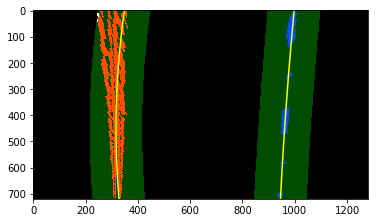

In [126]:
# Polynomial fit values from the previous frame(Initial value)
num_save_frame = 10
left_fit = np.array([0.00017865722983773904, -0.16397316200164028, 354.12094080667237])
right_fit = np.array([3.218296423168555e-05, -0.09620031973834556, 997.941125962164])
saved_left_fit = np.array([left_fit for i in range(num_save_frame)])
saved_right_fit = np.array([right_fit for i in range(num_save_frame)])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global saved_left_fit
    global saved_right_fit
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # avarage fitting paramters
    saved_left_fit = np.delete(saved_left_fit, 0, 0)
    saved_right_fit = np.delete(saved_right_fit, 0, 0)
    saved_left_fit = np.append(saved_left_fit, [left_fit], 0)
    saved_right_fit = np.append(saved_right_fit, [right_fit], 0)
    left_fit = np.mean(saved_left_fit, axis=0)
    right_fit = np.mean(saved_right_fit, axis=0)
    
    left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
    right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2]
    
    # Using parallel lane(mirror lane)
    """
    if len(lefty) == 0 or len(righty) == 0:
        left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
        right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2]
    elif len(lefty) > len(righty):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = left_fit 
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2]
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2] + (rightx[0] - leftx[0])
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        left_fit = right_fit 
        left_fitx = ploty**2 * left_fit[0] + ploty * left_fit[1] + left_fit[2] - (rightx[0] - leftx[0])
        right_fitx = ploty**2 * right_fit[0] + ploty * right_fit[1] + right_fit[2] 
    """
    
    # define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700
    ym_per_pix = 30/720 
    
    # calculate curvature
    l_curvature, r_curvature = measure_curvature_pixels(left_fit, right_fit, ploty, xm_per_pix, ym_per_pix)
    
    # calculate car position from the center point
    mid_pt = left_fitx[-1] + (right_fitx[-1] - left_fitx[-1]) // 2
    pos = (mid_pt - (img_shape[1] // 2)) * xm_per_pix
    
    return left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos

def measure_curvature_pixels(left_fit, right_fit, ploty, xm_per_pix, ym_per_pix):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    
    # calculate curvature
    y_eval = np.max(ploty)
    left_curvature = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curvature = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curvature, right_curvature

def search_around_poly(binary_warped):
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Gret the index of activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = search_around_poly(top_down_bin)
print('curvature of left lane = {}'.format(l_curvature))
print('curvature of right lane = {}'.format(r_curvature))
print('position from center = {}'.format(pos))

# View your output
plt.imshow(result)

### Visualization

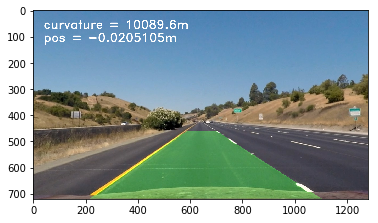

In [127]:
def visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M, l_curvature, r_curvature, pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(perspective_M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (top_down_bin.shape[1], top_down_bin.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    text = 'curvature = {:.6}m'.format((l_curvature + r_curvature) / 2) 
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    text = 'pos = {:.6}m'.format(pos) 
    cv2.putText(result, text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result
result = visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M, l_curvature, r_curvature, pos)
plt.imshow(result)

## Pipeline(video)

In [128]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [129]:
i = 0
def process_image(img):
    global i
    # get the undistorted image
    undistorted = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite('./origin/{}.png'.format(i), undistorted)
    # get lane binary image
    color_binary, combined_binary = pipeline(undistorted)
    cv2.imwrite('./bin/{}.png'.format(i), color_binary)
    # Perspective transformation 
    top_down_bin, perspective_M = warp_transform(combined_binary)
    top_down_color = cv2.cvtColor(top_down_bin*255, cv2.COLOR_GRAY2BGR)
    cv2.imwrite('./birdview/{}.png'.format(i), top_down_color)
    # lane finding and fitting
    result, left_fitx, right_fitx, ploty, l_curvature, r_curvature, pos = search_around_poly(top_down_bin)
    # visualize
    visualized_img = visualize_lane(undistorted, top_down_bin, left_fitx, right_fitx, ploty, perspective_M,
                                   l_curvature, r_curvature, pos)
    cv2.imwrite('./output/{}.png'.format(i), visualized_img)
    i += 1
    
    return visualized_img

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [17:57<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 18min 56s, sys: 2min 39s, total: 21min 36s
Wall time: 17min 58s


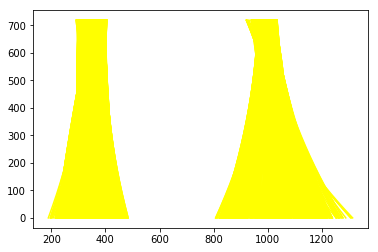

In [121]:
output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Play the video inline.

In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))